In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
text = open('./horoscopes1/horoscopes.csv', 'r', encoding="utf8").read()
text = text.split("\n")
res_text = ""
for line in text:
    if(len(line.split("|")) >= 2 and len(line) > 0):
        res_text += line.split("|")[1] + " "
text = res_text

In [3]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(text)


In [4]:
max_id = len(tokenizer.word_index)
dataset_size = tokenizer.document_count
print(max_id)
print(dataset_size)

56
3020120


In [5]:
[encoded] = np.array(tokenizer.texts_to_sequences([text])) - 1

In [6]:
train_size = dataset_size * 90 // 100

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [8]:
n_steps = 100
window_length = n_steps + 1
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [9]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [10]:
batch_size = 128
dataset = dataset.shuffle(buffer_size=batch_size * window_length).batch(batch_size).prefetch(1)
dataset = dataset.map(lambda windows: (windows[:,:-1], windows[:,1:]))


In [11]:
dataset = dataset.map(
    lambda X, Y:  (tf.one_hot(X, depth=max_id), Y)) 
dataset = dataset.prefetch(1)

In [12]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id], dropout=0.2, recurrent_dropout=0.3),
    keras.layers.GRU(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.3),
    keras.layers.TimeDistributed(keras.layers.Dense(128, activation='softmax'))
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
history = model.fit(dataset, epochs=32, steps_per_epoch=500)


Epoch 1/32
500/500 [==============================] - 402s 795ms/step - loss: 2.5353
Epoch 2/32
500/500 [==============================] - 383s 765ms/step - loss: 1.9627
Epoch 3/32
500/500 [==============================] - 381s 762ms/step - loss: 1.7648
Epoch 4/32
500/500 [==============================] - 386s 771ms/step - loss: 1.6097
Epoch 5/32
500/500 [==============================] - 386s 773ms/step - loss: 1.5370
Epoch 6/32
500/500 [==============================] - 389s 778ms/step - loss: 1.4592
Epoch 7/32
500/500 [==============================] - 389s 779ms/step - loss: 1.3956
Epoch 8/32
500/500 [==============================] - 386s 772ms/step - loss: 1.3744
Epoch 9/32
500/500 [==============================] - 388s 776ms/step - loss: 1.3594
Epoch 10/32
500/500 [==============================] - 383s 766ms/step - loss: 1.3069
Epoch 11/32
500/500 [==============================] - 381s 761ms/step - loss: 1.3173
Epoch 12/32
 96/500 [====>.........................] - ETA: 5:0

KeyboardInterrupt: 

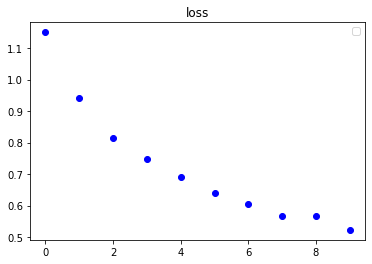

In [203]:
# Plot loss from keras history object
loss = history.history['loss']

import matplotlib.pyplot as plt
import math

plt.plot(range(10), [math.log(x) for x in loss], 'bo')
plt.title('loss')
plt.legend()

plt.show()

In [14]:
def preprocess(text):
    x = np.array(tokenizer.texts_to_sequences(text)) -1
    return tf.one_hot(x,max_id)

In [15]:
X_new = preprocess(["How are you"])


In [16]:
Y_pred = model.predict(X_new)


In [17]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    Y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(Y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]
def complete_text(text, n_chars=100,temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [18]:
model.predict(preprocess(["How are you"]))

array([[[8.8257536e-02, 3.2742897e-01, 8.7773211e-02, ...,
         8.1514381e-06, 9.0547655e-06, 9.0085214e-06],
        [4.7447085e-02, 6.3760835e-03, 1.4363359e-02, ...,
         3.8134468e-07, 4.9641477e-07, 2.0845846e-07],
        [7.6055747e-01, 5.2318253e-02, 1.6775826e-04, ...,
         6.7953914e-09, 1.0084706e-08, 6.2524279e-09],
        ...,
        [1.2468929e-05, 1.5461663e-03, 9.9777091e-01, ...,
         8.8545233e-09, 2.0742243e-08, 1.4357185e-08],
        [3.1857678e-06, 3.4665300e-07, 3.6895901e-06, ...,
         2.0825306e-09, 4.4600483e-09, 1.3834471e-08],
        [4.9764773e-01, 1.3647665e-04, 1.6837483e-06, ...,
         4.0938207e-08, 2.0099964e-08, 1.3479559e-08]]], dtype=float32)

In [28]:
complete_text("C",100,temperature=0.2)

'Could be all the world in your way to do it may be restract and don’t get to do it is the world it is'

In [29]:
model.save_weights('./horoscopes1/weights.h5')